In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.ndimage import gaussian_filter1d
from pyonset import Onset, BootstrapWindow
from anisotropy import run_SEPevent

In [39]:
data_path = f"{os.getcwd()}{os.sep}data"

onset_date = pd.to_datetime("2023-02-22")
start = onset_date - pd.Timedelta(days=1)
end = onset_date + pd.Timedelta(days=2)    # off by one, so three days are loaded now

event = run_SEPevent(data_path, spacecraft_instrument="Wind 3DP", starttime=start, endtime=end, species="e", channels=3, averaging="15min")

Input was Wind, using Wind.
Spacecraft: Wind
Instrument: 3DP. Species: e. Channels: 3.
11/15/2025 21:12:30 File is current: /home/osant/gradu/data/wind_masters/wi_h0_mfi_00000000_v01.cdf
11/15/2025 21:12:30 Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/
11/15/2025 21:12:30 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230221_v05.cdf
11/15/2025 21:12:30 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230222_v05.cdf
11/15/2025 21:12:30 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230223_v05.cdf


(<Figure size 800x500 with 5 Axes>,
 array([<Axes: title={'center': 'Wind'}>,
        <Axes: ylabel='Pitch angle [$\\degree$]'>,
        <Axes: xlabel='Universal Time (UT)', ylabel='Intensity\n [1/(s$\\,$cm²$\\,$sr$\\,$MeV)]'>],
       dtype=object))

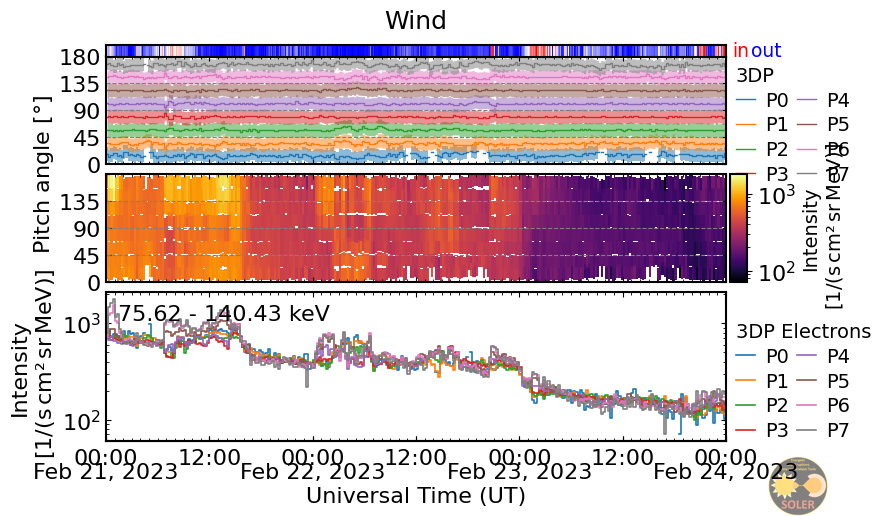

In [40]:
event.overview_plot()

1st idea: do Gaussian kernel smoothing on 15 minutes downsampled data. Find local optima of the time-series (look at where discrete difference changes signs). If consecutive optima with positive difference are an order of magnitude apart -> identify approximate onset there. Then do Poisson-CUSUM with 8 hrs initial background to get a better estimate of the onset. (Could consider hybrid method if computationally feasible but only an approximate one is needed, so this is easier)

Problem: ignores lower flux events entirely. Also Poisson-CUSUM wasn't effective at obtaining a good enough estimate since the backgrounds in most cases were very chaotic.

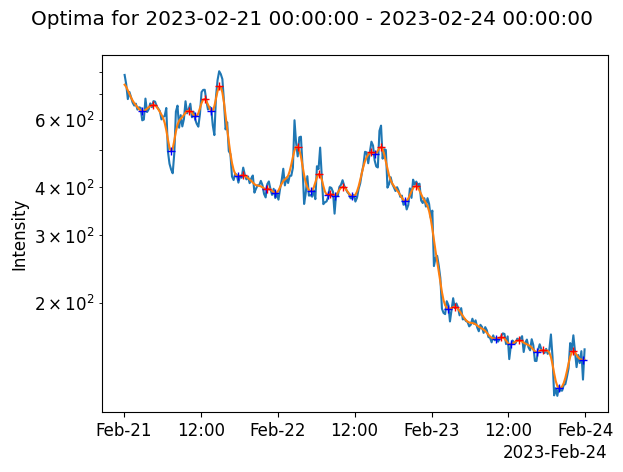

In [ ]:
from itertools import product

data = pd.Series(event.I_data[:,3], index=event.I_times)
data_smooth = gaussian_filter1d(data, sigma=2)
data_smooth_diff = np.diff(data_smooth)
arg_maxima = []
arg_minima = []
for i in range(len(data_smooth_diff)-1):
    if (data_smooth_diff[i + 1] > 0 and data_smooth_diff[i] < 0):
        arg_minima.append(i+1)
    elif (data_smooth_diff[i + 1] < 0 and data_smooth_diff[i] > 0):
        arg_maxima.append(i+1)

fig, ax = plt.subplots()
ax.plot(data)
ax.plot(data.index, data_smooth)
ax.plot(data.index[arg_minima], data_smooth[arg_minima], "b+")
ax.plot(data.index[arg_maxima], data_smooth[arg_maxima], "r+")
ax.set_yscale("log")
ax.set_ylabel("Intensity")
fig.suptitle(f"Optima for {start} - {end}")
fig.tight_layout()
plot_dir = f"{os.getcwd()}{os.sep}plots"
os.makedirs(plot_dir, exist_ok=True)
fname = plot_dir + os.sep + f"Wind_{start.strftime("%Y%m%d")}-{end.strftime("%Y%m%d")}"
fig.savefig(fname, bbox_inches="tight")

In [ ]:
def check_for_gaps(data, start, end, max_gap=1):
    flux_finite = data.dropna()
    for i in range(len(flux_finite[start:end]) - 1):
        if flux_finite.index[i + 1] - flux_finite.index[i] > pd.Timedelta(hours=max_gap):
            return True
        
    return False

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.ndimage import gaussian_filter1d
from pyonset import Onset, BootstrapWindow
from anisotropy import run_SEPevent

import sys
import logging
filehandler = logging.FileHandler(filename="wind_events.log", encoding="utf-8")
streamhandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %H:%M:%S', handlers=[filehandler, streamhandler], force=True)


data_path = f"{os.getcwd()}{os.sep}data"
csv_path = f"{os.getcwd()}{os.sep}wind_events.csv"

for d in range(14):
    date = pd.to_datetime("2023-02-20") + pd.Timedelta(days=d)
    logging.info(f"Analyzing flux for {date}")
    start = date - pd.Timedelta(days=1)
    end = date + pd.Timedelta(days=2)    # off by one, so three days are loaded now
    try:
        event = run_SEPevent(data_path, spacecraft_instrument="Wind 3DP", starttime=start, endtime=end, 
                            species="e", channels=3, averaging="60min")         # maybe wget SFPD, SOPD from CDAWeb if SSL Berkeley is down
    except ValueError:
        continue

    # Data smoothing and finite difference optimization
    data = pd.Series(event.I_data[:,3], index=event.I_times)
    data_smooth = gaussian_filter1d(data, sigma=1)   
    data_smooth_diff = np.diff(data_smooth)
    arg_extrema = []
    for i in range(len(data_smooth_diff)-1):
        if (data_smooth_diff[i + 1] > 0 and data_smooth_diff[i] < 0) or (data_smooth_diff[i + 1] < 0 and data_smooth_diff[i] > 0):
            arg_extrema.append(i+1)

    # Plot data, smoothed data and optima
    fig, ax = plt.subplots()
    ax.plot(data)
    ax.plot(data.index, data_smooth)
    ax.plot(data.index[arg_extrema], data_smooth[arg_extrema], "k+")
    ax.set_yscale("log")
    ax.set_ylabel("Intensity")
    fig.suptitle(f"Optima for {start} - {end}")
    fig.tight_layout()
    plot_dir = f"{os.getcwd()}{os.sep}plots"
    os.makedirs(plot_dir, exist_ok=True)
    fname = plot_dir + os.sep + f"Wind_{start.strftime("%Y%m%d")}-{end.strftime("%Y%m%d")}"
    fig.savefig(fname, bbox_inches="tight")
    plt.close(fig)

    # Rough onset determination with Poisson-CUSUM
    onset = Onset(start, end, "Wind", "3DP", "e", "l3", viewing="3", data_path=data_path)
    for i in range(len(arg_extrema) - 1):
        n = 0
        ext1 = arg_extrema[i]
        ext2 = arg_extrema[i+1]
        if (data.iloc[ext2] / data.iloc[ext1] > 10) \
        and (data.iloc[ext2] > data.iloc[ext1]) \
        and check_for_gaps(data, data.index[ext1], data.index[ext2]) is False:
            
            logging.info(f"Found a potential event between {data[arg_extrema].index[i]} - {data[arg_extrema].index[i+1]}")
            bg_end = data[arg_extrema].index[i]
            bg_start = bg_end - pd.Timedelta(hours=8)
            background = BootstrapWindow(bg_start, bg_end, bootstraps=1000)
            single_onset_stats, flux_series = onset.cusum_onset(channels=[3], background_range=background, 
                                                                        viewing="3", resample="1min", cusum_minutes=60,
                                                                        plot=False)
            try:
                onset_date = single_onset_stats[-1].date()
                onset_time = single_onset_stats[-1].time()
                logging.info(f"Poisson-CUSUM result: found onset {onset_date} {onset_time}\n" \
                             f"using background {bg_start} - {bg_end}")
                
                # Write to CSV
                with open(csv_path, "+r", encoding="utf-8") as fp:
                    event_no = len(fp.readlines())
                    fp.write(f"{event_no},{onset_date},{onset_time},{bg_start},{bg_end}\n")
                    logging.info(f"Results successfully saved to {csv_path}")
                    fp.close()
                
                n += 1

            except AttributeError:
                logging.info(f"Sufficient minimum ({ext1}) and maximum ({ext2}) were identified, but no onset was found")

    logging.info(f"Analysis for day {date} finished, {n} onsets found")

2nd idea: take maximum and minimum of the intensity such that the minimum precedes the maximum. Do "rolling" Poisson-CUSUM of a given window starting from the minimum up to the maximum. Take median onset.

Problem: with a gradual event the CUSUM estimates don't settle into a single value, so no clear mode is obtained. Also only going up to the maximum fails to identify smaller events past that maximum.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess

from scipy.ndimage import gaussian_filter1d
from pyonset import Onset, BootstrapWindow
from anisotropy import run_SEPevent

import sys
import logging
filehandler = logging.FileHandler(filename="wind_events.log", encoding="utf-8")
streamhandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %H:%M:%S', handlers=[filehandler, streamhandler], force=True)

import warnings

warnings.filterwarnings("ignore", "WARNING: background mean is nan!", category=UserWarning, module="pyonset")

def check_for_gaps(data, start, end, max_gap=1):
    flux_finite = data.dropna()
    for i in range(len(flux_finite[start:end]) - 1):
        if flux_finite.index[i + 1] - flux_finite.index[i] > pd.Timedelta(hours=max_gap):
            return True
    return False

data_path = f"{os.getcwd()}{os.sep}data"
csv_path = f"{os.getcwd()}{os.sep}wind_events.csv"

year = sys.argv[1]
#rc = subprocess.call(f'wget -r -nv --show-progress --tries=10 -nc -nH -np -nd -P "data" -A "*.cdf" "https://cdaweb.gsfc.nasa.gov/pub/data/wind/3dp/3dp_sfpd/{year}/"'.split(" "))

for d in range(365):
    date = pd.to_datetime(f"2023-01-01") + pd.Timedelta(days=d)
    logging.info(f"Analyzing flux for {date}")

    start = date - pd.Timedelta(days=1)
    end = date + pd.Timedelta(days=2)    # off by one, so three days are loaded now
    try:
        event = run_SEPevent(data_path, spacecraft_instrument="Wind 3DP", starttime=start, endtime=end, 
                            species="e", channels=3, averaging="60min")         # maybe wget SFPD, SOPD from CDAWeb if SSL Berkeley is down
    except ValueError:
        continue

    # Data smoothing and finite difference optimization
    data = pd.Series(event.I_data[:,3], index=event.I_times)
    data_smooth = gaussian_filter1d(data, sigma=1)   
    data_smooth_diff = np.diff(data_smooth)
    arg_max = np.nanargmax(data_smooth[(data.index[0] + pd.Timedelta(hours=12)):(data.index[-1] + pd.Timedelta(hours=12))])
    
    arg_min = np.nanargmin(data_smooth[(data.index[0] + pd.Timedelta(hours=12)):arg_max])

    time_min = data.index[arg_min]
    time_max = data.index[arg_max]
    # for i in range(len(data_smooth_diff)-1):
    #     if (data_smooth_diff[i + 1] > 0 and data_smooth_diff[i] < 0) or (data_smooth_diff[i + 1] < 0 and data_smooth_diff[i] > 0):
    #         arg_optima.append(i+1)

    # Plot data, smoothed data and optima
    fig, ax = plt.subplots()
    ax.plot(data, label="Data")
    ax.plot(data.index, data_smooth, label="Smoothed data")
    ax.plot(time_min, data.iloc[arg_min], "bx", markersize=10, label="Minimum")
    ax.plot(time_max, data.iloc[arg_max], "rx", markersize=10, label="Maximum")
    ax.legend()
    ax.set_yscale("log")
    ax.set_ylabel("Intensity")
    fig.suptitle(f"{start} - {end}")
    fig.tight_layout()
    plot_dir = f"{os.getcwd()}{os.sep}plots"
    os.makedirs(plot_dir, exist_ok=True)
    fname = plot_dir + os.sep + f"Wind_{start.strftime("%Y%m%d")}-{end.strftime("%Y%m%d")}"
    fig.savefig(fname, bbox_inches="tight")
    plt.close(fig)
    
    # Rough onset determination with median value from "rolling" Poisson-CUSUM:
    # slide a 12 hour window from minimum up to maximum, calculating Poisson-CUSUM estimate with each window.
    # Final rough onset estimate is taken to be the median value
    onset = Onset(start, end, "Wind", "3DP", "e", "l3", viewing="3", data_path=data_path)
    resample = "1min"
    window_len = 12
    n = 0
    onsets = []
    for i in range(int((time_max - time_min).total_seconds() // 60 // 60)):
        
        window_end = data.index[arg_min] + i * pd.Timedelta(hours=i)
        window_start = window_end - pd.Timedelta(hours=window_len)
        #background = BootstrapWindow(window_start, window_end, bootstraps=1000)
        single_onset_stats, flux_series = onset.cusum_onset(channels=[3], background_range=[window_start, window_end], 
                                                                    viewing="3", resample=resample, cusum_minutes=120,
                                                                    plot=False)
        
        if isinstance(single_onset_stats[-1], pd._libs.tslibs.NaTType):
            logging.info(f"No onset with background {window_start} - {window_end}")
            continue
        else:
            logging.info(f"Found onset with background {window_start} - {window_end}: {single_onset_stats[-1]}")
            onsets.append(single_onset_stats[-1])

    onset_times = pd.Series(onsets) 
    median_onset = onset_times.median()

    logging.info(f"Determined median onset: {median_onset}")
    
    # Write to CSV
    with open(csv_path, "+r", encoding="utf-8") as fp:
        event_no = len(fp.readlines())
        fp.write(f"{event_no},{median_onset.date()},{median_onset.time()},{time_min},{time_max}\n")
        logging.info(f"Results successfully saved to {csv_path}")
        fp.close()


3rd idea: just take rolling Poisson-CUSUM for the whole day, and take the onset mode(s). At least all the clear cut events (with no data gaps) will be identified using this method but so will many other smaller "non-events". Median filter with kernel size 5 was used to remove sharp glitch peaks (for convenience, other methods also available). This removes noise from the signal, effectively making the CUSUM method a lot more sensitive. Then again, because the backgrounds are so chaotic, it shouldn't make much difference.

In [ ]:
def remove_glitches(data, tol=100, max_len_min=15):
    """
    If there are opposite-signed differences more than a specified tolerance level apart and their temporal separation is
    at most max_len_min, set these values and every value in between as missing. 
    """
    diff = data.diff()
    for i, date in enumerate(diff.index):
        diff_window = diff[date:date+pd.Timedelta(minutes=max_len_min)]
        if abs(diff_window.iloc[0]) > tol:
            for j, diff_date in enumerate(diff_window.index):
                if abs(diff_window.iloc[j]) > tol and diff_window.iloc[0] > diff_window.iloc[j]:
                    data[date:diff_date] = pd.NA
                    break

    return data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
import traceback
from time import sleep
import requests

from scipy.signal import medfilt
from pyonset import Onset, BootstrapWindow
from seppy.util import resample_df
from anisotropy import run_SEPevent

import sys
import logging
filehandler = logging.FileHandler(filename="wind_events_test.log", encoding="utf-8")
streamhandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %H:%M:%S', handlers=[filehandler, streamhandler], force=True)

import warnings

warnings.filterwarnings("ignore", "WARNING: background mean is nan!", category=UserWarning, module="pyonset")

def check_for_gaps(data, start, end, max_gap=1):
    flux_finite = data.dropna()
    for i in range(len(flux_finite[start:end]) - 1):
        if flux_finite.index[i + 1] - flux_finite.index[i] > pd.Timedelta(hours=max_gap):
            return True
    return False

data_path = f"{os.getcwd()}{os.sep}data"
csv_path = f"{os.getcwd()}{os.sep}wind_events_test.csv"
plot_dir = f"{os.getcwd()}{os.sep}plots_test"
os.makedirs(plot_dir, exist_ok=True)

#year = sys.argv[1]
#rc = subprocess.call(f'wget -r -nv --show-progress --tries=10 -nc -nH -np -nd -P "data" -A "*.cdf" "https://cdaweb.gsfc.nasa.gov/pub/data/wind/3dp/3dp_sfpd/{year}/"'.split(" "))

# TODO: to handle request errors, change this to a while loop: 
for d in range(10):
    try:
        date = pd.to_datetime(f"2005-01-01") + pd.Timedelta(days=d)
        logging.info(f"Analyzing flux for {date}")

        start = date - pd.Timedelta(days=1)
        end = date + pd.Timedelta(days=2)    # off by one, so three days are loaded
        
        event = run_SEPevent(data_path, spacecraft_instrument="Wind 3DP", starttime=start, endtime=end, 
                            species="e", channels=3, averaging="5min")         # maybe wget data from CDAWeb if SSL Berkeley is down
        
        
        # Do median filtering with kernel size of 3. This alters the underlying data statistics but easily removes erroneous peak values.
        # The point is only to get a rough estimate for the onset.
        data = pd.Series(event.I_data[:,3], index=event.I_times)

        # Rough onset determination with median value from "rolling" Poisson-CUSUM:
        # slide a window over the whole day, calculating Poisson-CUSUM estimate with each window.
        # Mode of determined onsets is taken to be the (or an) onset
        onset = Onset(start, end, "Wind", "3DP", "e", "l3", viewing="3", data_path=data_path)
        resample = "5min"
        window_len = 6
        n = 0
        onsets = []
        onset_found = False

        #background = BootstrapWindow(window_start, window_end, bootstraps=1000)
        
        for i in range(24):
            window_end = date + pd.Timedelta(hours=i) # from start of the middle day
            window_start = window_end - pd.Timedelta(hours=window_len)
            #background = BootstrapWindow(window_start, window_end, bootstraps=1000)
            single_onset_stats, flux_series = onset.cusum_onset(channels=3, background_range=[window_start, window_end], 
                                                                        viewing="3", resample=resample, cusum_minutes=120,
                                                                        sigma_multiplier=2, plot=False, erase=True)     # erase = True -> median filtering with kernel_size=5 (my own mod)
            
            if isinstance(single_onset_stats["onset_time"], pd._libs.tslibs.NaTType):
                continue
            else:
                logging.info(f"Found onset with background {window_start} - {window_end}: {single_onset_stats["onset_time"]}")
                onsets.append(single_onset_stats["onset_time"])
                onset_found = True

        if onset_found:
            onset_times = pd.Series(onsets) 
            onset_result = onset_times.mode()[0] 

            # NOTE: for now, only take the most common value. Decide how to handle days with multiple events, if there are any
            # if len(onset_modes) > 1:
            #     pass

            logging.info(f"Determined onset: {onset_result}")

            # Write to CSV
            with open(csv_path, "+r", encoding="utf-8") as fp:
                event_no = len(fp.readlines())
                fp.write(f"{event_no},{onset_result.date()},{onset_result.time()}\n")
                logging.info(f"Results successfully saved to {csv_path}")
                fp.close()

        else:
            logging.info(f"No onsets found for {date}")

        fig, ax = plt.subplots()

        ax.step(flux_series.index, flux_series)
        if onset_found:
            ax.axvline(onset_result, color="red")

        ax.set_yscale("log")
        ax.set_ylabel("Intensity")
        fig.suptitle(f"Onset determination for {date}")
        fig.tight_layout()
        
        fname = plot_dir + os.sep + f"Wind_{date.strftime("%Y%m%d")}"
        fig.savefig(fname, bbox_inches="tight")
        plt.close(fig)
    except requests.exceptions.ReadTimeout:
        d -= 1
        sleep(60)
    except Exception:
        logging.info(f"{traceback.format_exc()}")


11/17/2025 18:35:53 Analyzing flux for 2023-01-12 00:00:00
Input was Wind, using Wind.
Spacecraft: Wind
Instrument: 3DP. Species: e. Channels: 3.
11/17/2025 18:36:00 File is current: /home/osant/gradu/data/wind_masters/wi_h0_mfi_00000000_v01.cdf
11/17/2025 18:36:00 Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/
11/17/2025 18:36:01 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230111_v05.cdf
11/17/2025 18:36:03 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230112_v05.cdf
11/17/2025 18:36:04 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230113_v05.cdf
11/17/2025 18:36:20 Found onset with background 2023-01-11 18:00:00 - 2023-01-12 00:00:00: 2023-01-13 01:47:30.271000
11/17/2025 18:36:20 Found onset with background 2023-01-11 19:00:00 - 2023-01-12 01:00:00: 2023-01-13 00:42:30.271000
11/17/2025 18:36:20 Found onset with background 2023-01-11 20:00:00 - 2023-01-12 02:00:00: 2023-01-13 00:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import traceback
from itertools import product
from seppy.tools import Event
from seppy.loader.wind import wind3dp_load
from statsmodels.tsa.stattools import ccf
from seaborn import PairGrid
data_path = f"{os.getcwd()}{os.sep}data"
csv_path = f"{os.getcwd()}{os.sep}wind_events_test.csv"
plot_dir = f"{os.getcwd()}{os.sep}plots_3sigma"


Multi-index function only available (and necessary) for pitch-angle resolved fluxes. Skipping.


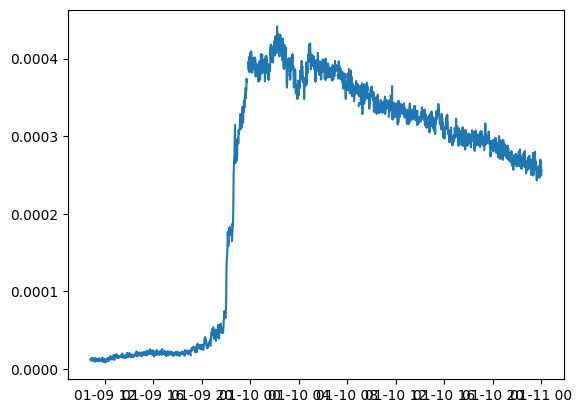

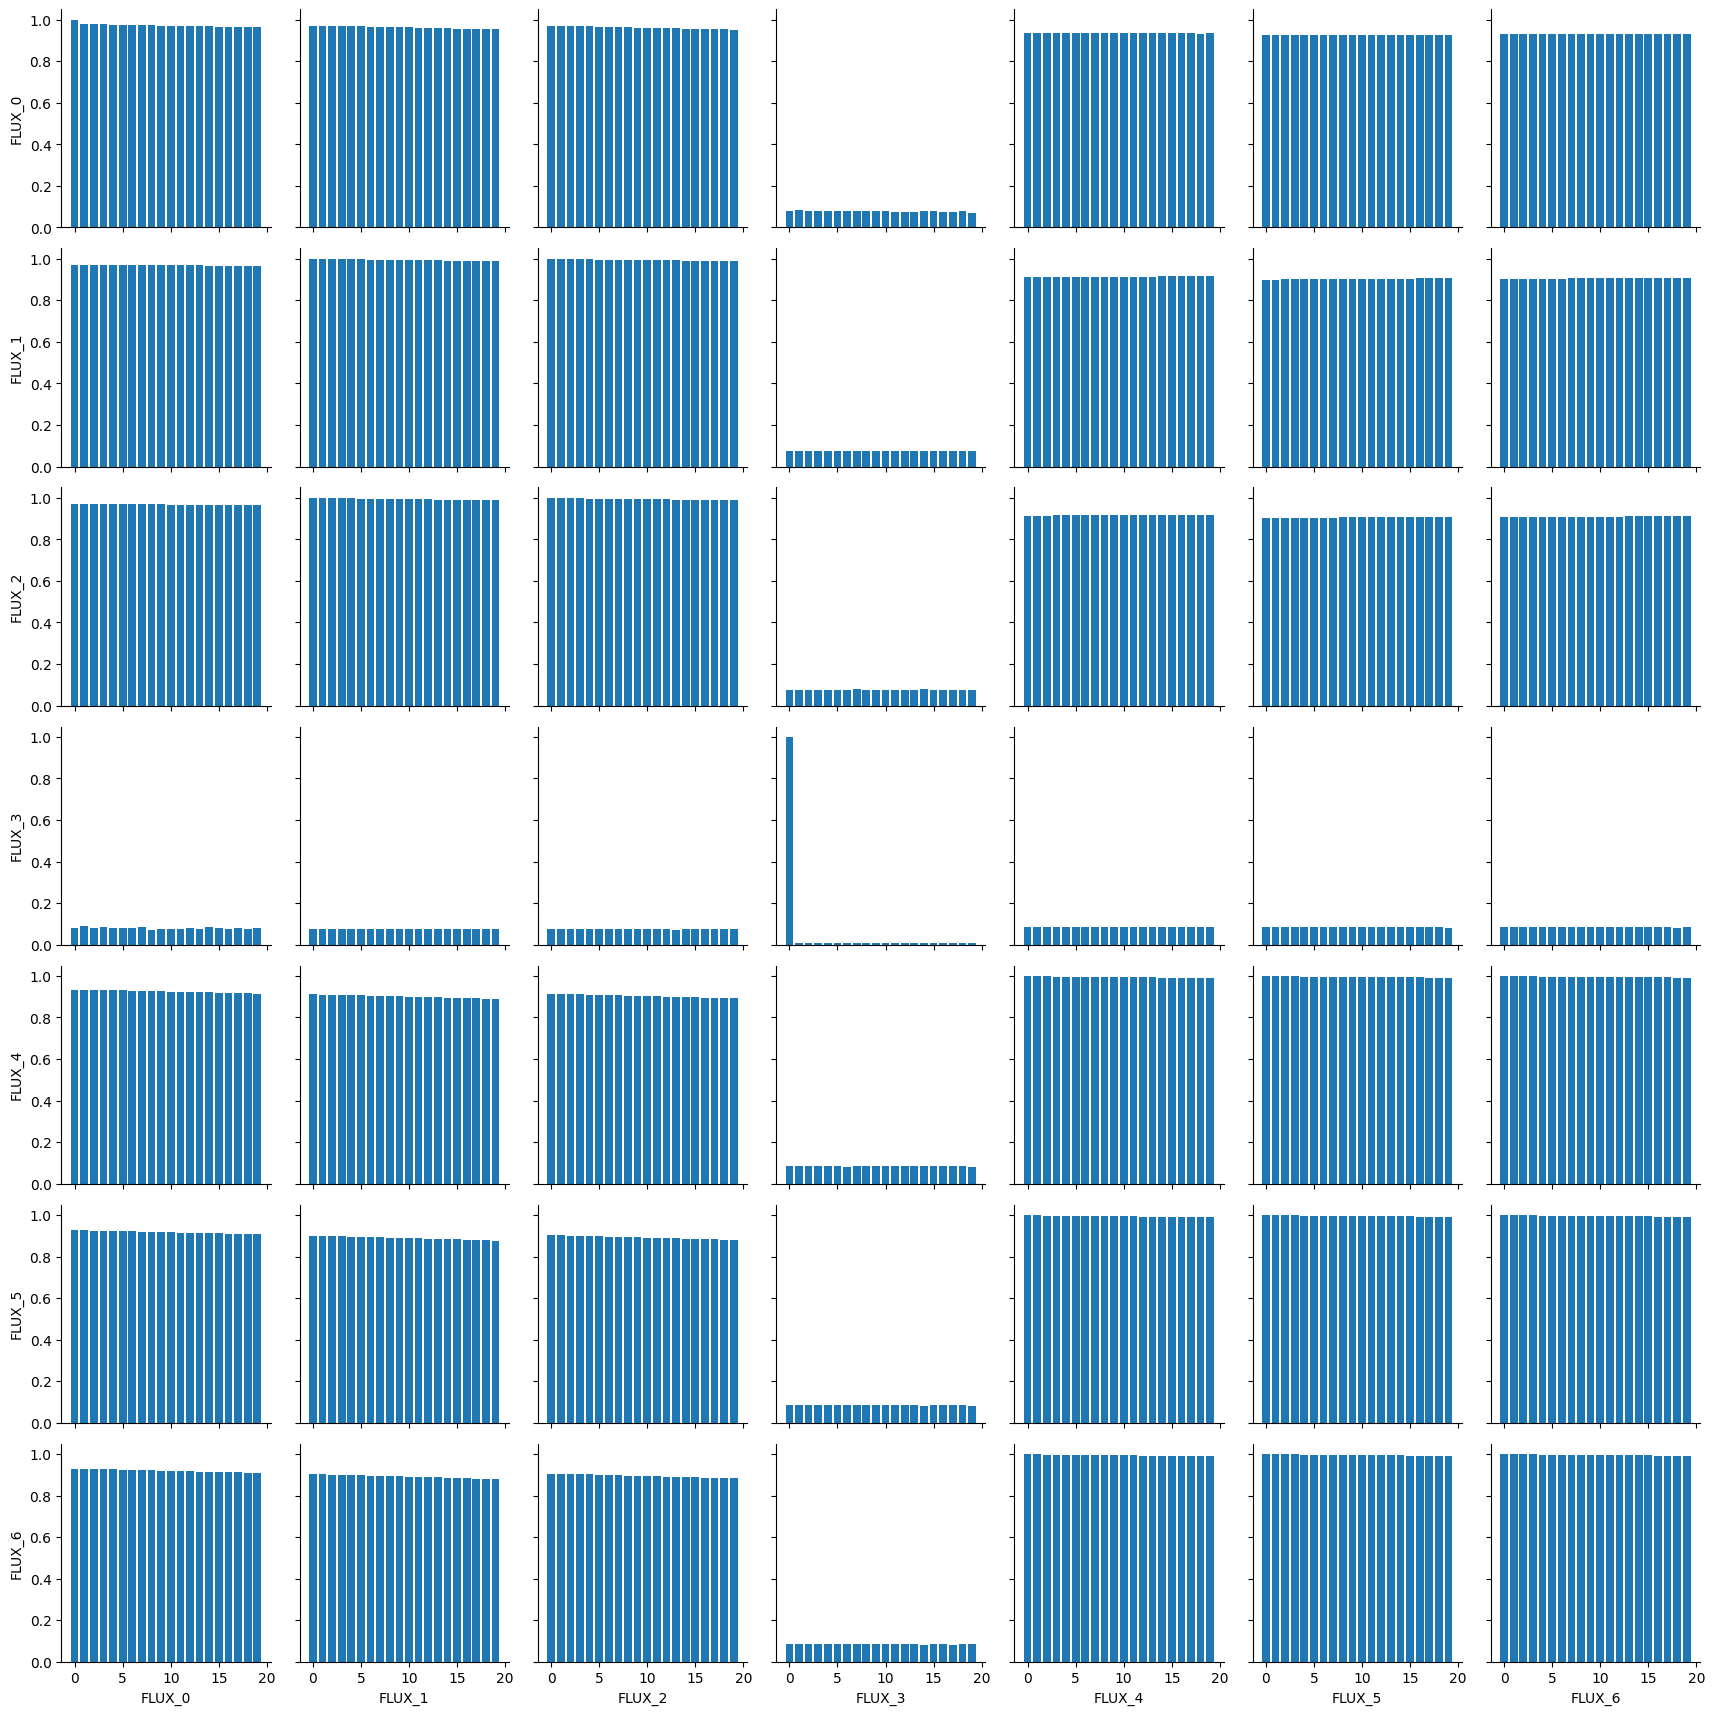

In [10]:
start = pd.to_datetime("2023-01-09")
end = pd.to_datetime("2023-01-11")

df_wind_omni, meta_wind_omni = wind3dp_load("WI_SFSP_3DP", start, end, path=data_path)
flux_list = [f"FLUX_{i}" for i in range(7)]

plt.plot(df_wind_omni["FLUX_5"])
def ccf_sns_wrapper(x, y, nlags=20, **kwargs):
    cross_corr = ccf(x.dropna(), y.dropna(), nlags=nlags)
    plt.bar(x=range(len(cross_corr)), height=cross_corr, **kwargs)

grid = PairGrid(df_wind_omni[flux_list], dropna=True)
grid.map(ccf_sns_wrapper)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
import traceback
from time import sleep
import requests

from anisotropy import run_SEPevent

import sys
import logging
filehandler = logging.FileHandler(filename="wind_events_test.log", encoding="utf-8")
streamhandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %H:%M:%S', handlers=[filehandler, streamhandler], force=True)

import warnings
warnings.filterwarnings("ignore", "WARNING: background mean is nan!", category=UserWarning, module="pyonset")

# def check_for_gaps(data, start, end, max_gap_mins=10):
#     flux_finite = data.dropna()
#     for i in range(len(flux_finite[start:end]) - 1):
#         if flux_finite.index[i + 1] - flux_finite.index[i] > pd.Timedelta(minutes=max_gap_mins):
#             return True
#     return False

year = 2012

data_path = f"{os.getcwd()}{os.sep}data"
csv_path = f"{os.getcwd()}{os.sep}wind_events_{year}.csv"
plot_dir = f"{os.getcwd()}{os.sep}/plots_4sigma/{year}"
os.makedirs(plot_dir, exist_ok=True)

d = 0   # day counter
j = 0   # retry counter
MAX_RETRIES = 5

while d < 365:
    try:
        onset_found = False
        resample = "5min"
        resample_int = int(resample.removesuffix("min"))
        window_len = 1
        onsets = []
        peaks = []

        date = pd.to_datetime(f"{year}-01-01") + pd.Timedelta(days=d)
        next_date = date + pd.Timedelta(days=1)
        logging.info(f"Analyzing flux for {date}")

        start = date - pd.Timedelta(days=1)
        end = date + pd.Timedelta(days=2)

        # d = start.strftime("%Y%m%d")
        # while d != end:
        #     rc = subprocess.call(f'wget -r -nv --show-progress --tries=10 -nc -nH -np -nd -P "data" -A "*_{d}_*.cdf" "https://cdaweb.gsfc.nasa.gov/pub/data/wind/3dp/3dp_sfpd/{year}/"'.split(" "))
        
        event = run_SEPevent(data_path, spacecraft_instrument="Wind 3DP", starttime=start, endtime=end, 
                            species="e", channels=3, averaging=resample)         # maybe wget data from CDAWeb if SSL Berkeley is down
        
        data = pd.Series(event.I_data[:,3], index=event.I_times).ffill(limit=2)
        event.wind_peak_removal(n_lim=2)   # Wind has some high flux peaks lasting for a couple of minutes. Remove these
        data = pd.Series(event.I_data[:,3], index=event.I_times).ffill(limit=2) # do this twice since first removal doesnt work if preceding value is missing -> fill missing values with previous values
        
        # 4-sigma method (Krucker et al. 1999, modified)        # TODO: 3-sigma instead, and 15 min averaging
        i = 0
        while i < len(data[date:next_date] - 1):
            # 1: calculate window mean and std
            window_end = date + pd.Timedelta(minutes=resample_int*i) # first window ends at the end of the 1st day
            window_start = window_end - pd.Timedelta(hours=window_len)
            # if check_for_gaps(data, window_start, window_end, max_gap_mins=10): 
            #     if not data_gaps_present:
            #         logging.info("Data gaps present, onset not determined")
            #         data_gaps_present = True
            #     continue
            # else:
            #     data_gaps_present = False
            window = data[window_start:window_end]
            window_mean = window.mean()
            window_std = window.std()            
            
            # 2: z-standardise (if following Krucker et al)
            
            I_z = (data[window_end:].dropna() - window_mean) / window_std
            
            peak_flux = np.nanmax(data[window_start:window_end + pd.Timedelta(hours=2)])  # peak flux within window_len + 2 hours
            peaks.append(peak_flux)
            # 3: check next point for 4 sigma deviation. If true, take the last timestamp of bg subtracted flux < 0 as onset
            # or maybe check if few of the next points are all above 4 sigma, so flukes won't trigger the method
            next_points = I_z.iloc[0:5]     # next 5 points
                
            if (next_points > 4).sum() == len(next_points): 
                onset_found = True
                onset_result = window.index[window <= window_mean][-1]
                logging.info(f"Found onset with background {window_start} - {window_end}: {onset_result}")
                onsets.append(onset_result)
                # Write to CSV
                with open(csv_path, "+r", encoding="utf-8") as fp:
                    event_no = len(fp.readlines())
                    fp.write(f"{event_no},{onset_result.date()},{onset_result.time()},{peak_flux}\n")
                    logging.info(f"Results successfully saved to {csv_path}")
                    fp.close()

                # Once an onset has been found, skip 2 hours ahead.
                i += 120 // resample_int
            
            else:
                i += 1

        fig, ax = plt.subplots()

        ax.step(data[date:next_date].index, data[date:next_date])
        if onset_found:
            for time in onsets: 
                ax.axvline(time, color="red")

        ax.set_yscale("log")
        ax.set_ylim(None, 1e2 if max(peaks) < 1e2 else None)
        ax.set_ylabel("Intensity")
        fig.suptitle(f"Onset determination for {date}")
        fig.tight_layout()
        
        fname = plot_dir + os.sep + f"Wind_{date.strftime("%Y%m%d")}"
        fig.savefig(fname, bbox_inches="tight")
        plt.close(fig)
        d += 1

    except requests.exceptions.ReadTimeout:
        logging.info(f"{traceback.format_exc()}")
        if j < MAX_RETRIES:
            j += 1
            sleep(60)
        else:
            logging.info("Download retries exceeded, quitting...")
            break
    except Exception:
        logging.info(f"{traceback.format_exc()}")
        d += 1